# <h1><center>*Forecasting Colombia's Weather*</center></h1>

# Goals:

 - Build a model to best forcast Colombia's weather
 ___

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import acquire as a
import prepare as p


import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from math import sqrt

---------------------------------------------------------------------------------------------------------------

# Acquire

 - Data acquired through kaggle
 - Wrote a function in my acquire.py file that extracts the data from a csv
 - It contained 577,462 rows and 4 columns before cleaning
 - Each row represents a country's information regarding weather
 - Each column represents a feature of the dataset 
 
 __________

# Prepare

 - Selected only the data pertaining to Colombia
 - Renamed columns
 - Removed columns that were not useful, made a column (month)
 - Checked for nulls in the data
 - Removed nulls which were first 15 years of data
 - Checked that column data types were appropriate
 - Made date column into data time 
 - Reset index to date. time 
 - Resampled data into months
 - Split data into train, validate and test (approx. 70/20/10)
 
 
 _____

# Data Dictionary


| Target Variable |     Definition     |
| :---------------: | :------------------: |
|      avg_temp     | average temperature |

| Feature  | Definition |
| :-------------: | :-------------: |
| date | date of the temperature was recorded (Index)  |
| avg_temp_uncertainty | average temperature of uncertainty  |
| country | location of origin data |
| month | the month the data was recorded|

_____

# A brief look at the data

In [2]:
# acquiring and cleaning the data
df = a.get_temp_data()
df, df_resampled = p.clean_df(df)

In [3]:
df.head()

,avg_temp,avg_temp_uncertainty,country
date,,,
1846-01-01,25.977,1.314,Colombia
1846-02-01,25.614,1.100,Colombia
1846-03-01,26.131,1.174,Colombia
1846-04-01,23.857,1.139,Colombia
1846-05-01,24.321,1.328,Colombia


In [4]:
df_resampled.head()

,avg_temp,avg_temp_uncertainty
date,,
1846-01-31,25.977,1.314
1846-02-28,25.614,1.100
1846-03-31,26.131,1.174
1846-04-30,23.857,1.139
1846-05-31,24.321,1.328


## Data splitting

In [5]:
# splitting data into train, validate, and test
train_size = int(round(df_resampled.shape[0] * 0.7)) + 1
validate_size = int(round(df_resampled.shape[0] * 0.2))
test_size = int(round(df_resampled.shape[0] * 0.1))
train_size, validate_size, test_size

(1409, 402, 201)

In [6]:
len(df_resampled) == train_size + validate_size + test_size

True

In [7]:
validate_end_index = train_size + validate_size
validate_end_index

train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]


In [8]:
#displaying all columns and getting first 5 rows
train.head()

,avg_temp,avg_temp_uncertainty
date,,
1846-01-31,25.977,1.314
1846-02-28,25.614,1.100
1846-03-31,26.131,1.174
1846-04-30,23.857,1.139
1846-05-31,24.321,1.328


# Explore

### *A look at our split data*

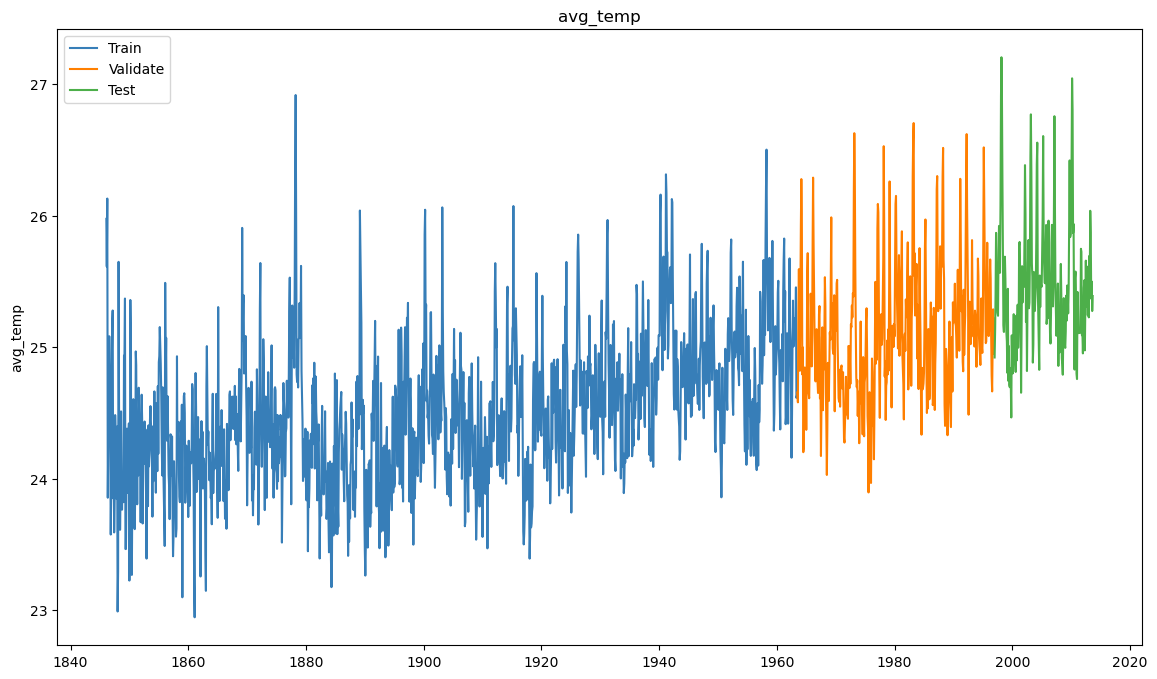

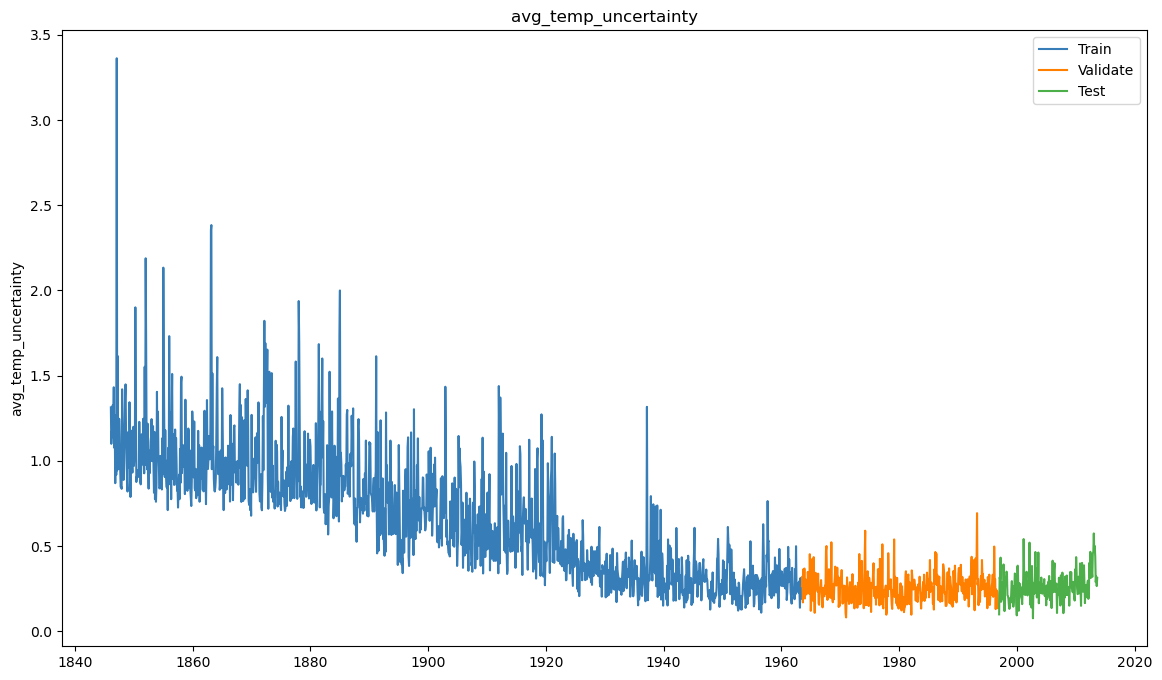

In [9]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [10]:
train['month'] = train.index.month_name()
train.head(1)

,avg_temp,avg_temp_uncertainty,month
date,,,
1846-01-31,25.977,1.314,January


**Takeaways**

- It seems like average temperature has been rising over time

____

## Distribution of data 

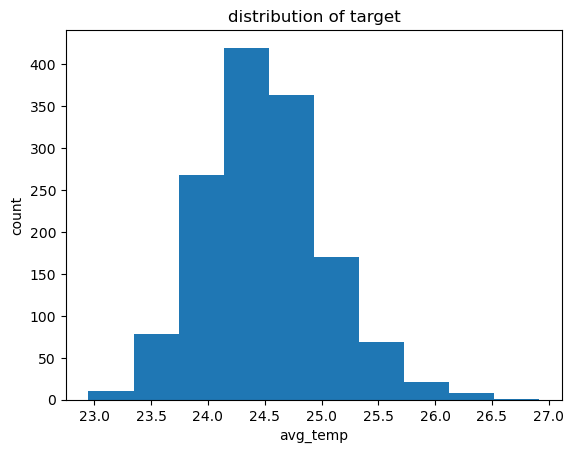

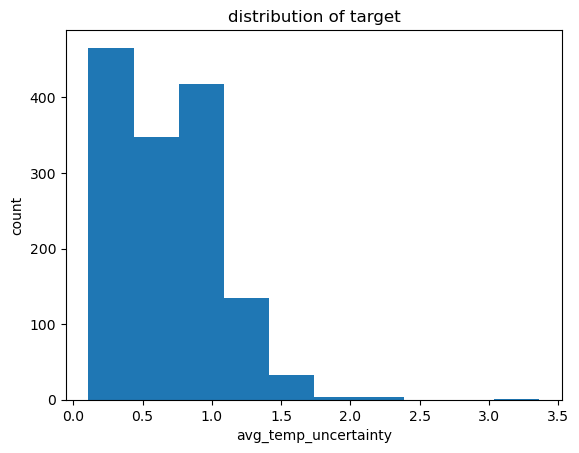

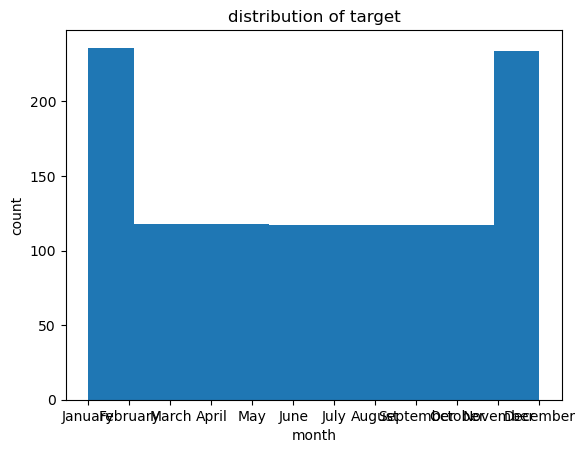

In [11]:
for col in train.columns:
    plt.hist(train[col])
    plt.xlabel(col)
    plt.ylabel('count')
    plt.title('distribution of target')
    plt.show()

**Takeaways**

- It seems like theres a pretty good distribution of average temperatures throughout the data history


--------

In [12]:
month_mean = train['avg_temp'].resample('M').mean()
month_mean = pd.DataFrame(month_mean)
month_mean['shifted'] = month_mean['avg_temp'].shift(-1)

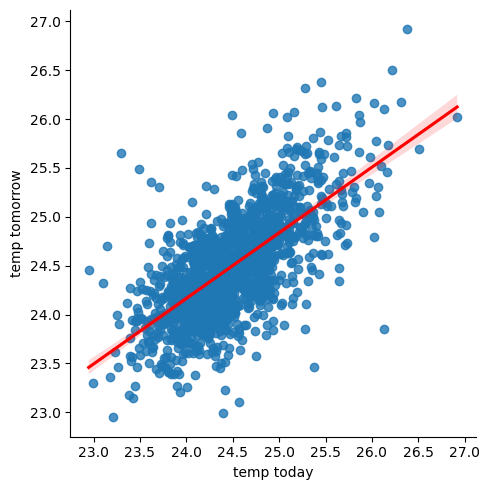

In [13]:
sns.lmplot(data = month_mean, x = 'avg_temp', y = 'shifted', line_kws= {'color': 'red'})
plt.xlabel('temp today')
plt.ylabel('temp tomorrow')
plt.show()

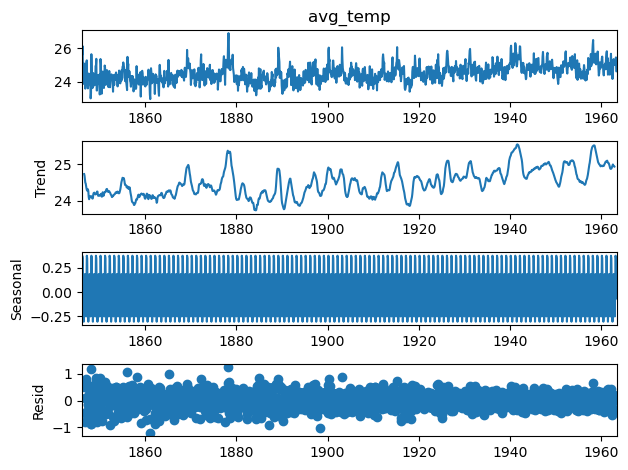

In [14]:
result = sm.tsa.seasonal_decompose(train['avg_temp'].resample('M').mean())

result.plot()
plt.show()

# Modeling 

- Goal is to minimize RMSE, so this will be my evaluation metric
- Ran 3 models
- I evaluated the models on train and validate data 
- The best performing model then was evaluated on test data subset

In [15]:
#base dataframe to evaluate models
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [16]:
train = train.iloc[:,0]
train = pd.DataFrame(train)
last_temp = train['avg_temp'][-1:][0]
yhat_df = pd.DataFrame(
    {'avg_temp': last_temp},
    index=validate.index)

yhat_df.head()

,avg_temp
date,
1963-06-30,24.633
1963-07-31,24.633
1963-08-31,24.633
1963-09-30,24.633
1963-10-31,24.633


### Functions to evaluate and plot my models

In [17]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 7)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)    

### Last observed model

avg_temp -- RMSE: 1


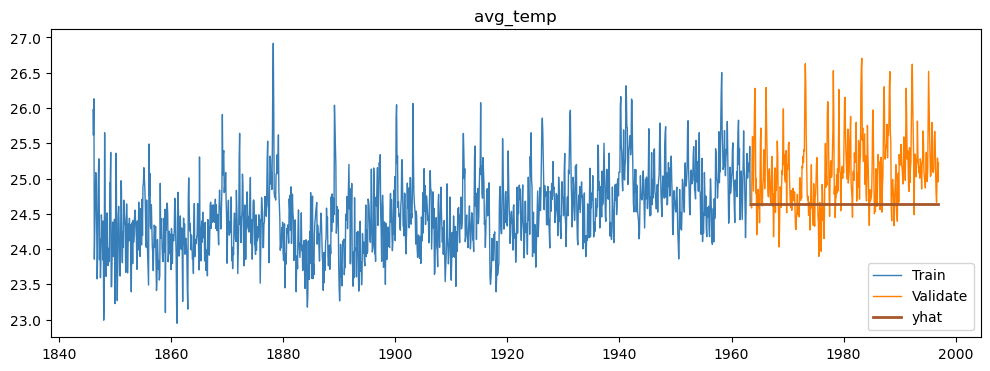

In [18]:
#last observed model compared to train and validate data
for col in train.columns:
    plot_and_eval(col)

In [19]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,0.688604


In [20]:
def make_baseline_predictions(temp_predictions=None):
    yhat_df = pd.DataFrame({'avg_temp': temp_predictions},
                          index=validate.index)
    return yhat_df

### Moving average model

In [21]:
# 9 months moving average model
period=9
train['avg_temp'].rolling(period).mean()
rolling_amount = round(train['avg_temp'].rolling(period).mean()[-1], 3)
yhat_df = make_baseline_predictions(rolling_amount)
yhat_df.head()

,avg_temp
date,
1963-06-30,25.068
1963-07-31,25.068
1963-08-31,25.068
1963-09-30,25.068
1963-10-31,25.068


avg_temp -- RMSE: 0


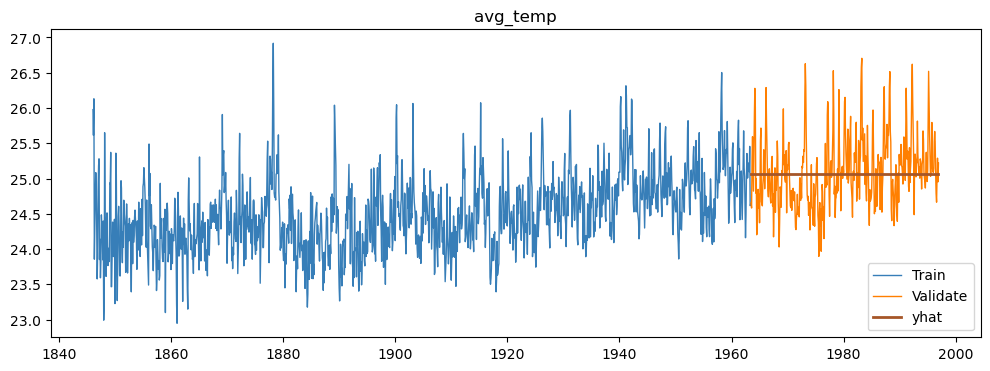

In [22]:
for col in train.columns:
    plot_and_eval(col)

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '9mo_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,0.688604
1,9mo_moving_avg,avg_temp,0.499906


### Holts seasonal model

In [24]:
#model with a seasonal period of 5 years or 60 months
hst_temp_fit1 = ExponentialSmoothing(train.avg_temp, seasonal_periods=60, trend='add', seasonal='add').fit()
hst_temp_fit2 = ExponentialSmoothing(train.avg_temp, seasonal_periods=60, trend='add', seasonal='mul').fit()
hst_temp_fit3 = ExponentialSmoothing(train.avg_temp, seasonal_periods=60, trend='add', seasonal='add', damped=True).fit()
hst_temp_fit4 = ExponentialSmoothing(train.avg_temp, seasonal_periods=60, trend='add', seasonal='mul', damped=True).fit()


In [25]:
results_amount=pd.DataFrame({'model':['hst_temp_fit1', 'hst_temp_fit2', 'hst_temp_fit3', 'hst_temp_fit4'],
                              'SSE':[hst_temp_fit1.sse, hst_temp_fit2.sse, hst_temp_fit3.sse, hst_temp_fit4.sse]})
results_amount.sort_values(by='SSE')

,model,SSE
3,hst_temp_fit4,164.065200
2,hst_temp_fit3,164.885706
1,hst_temp_fit2,165.232065
0,hst_temp_fit1,166.038780


In [26]:
# best holts seasonal model
yhat_df = pd.DataFrame({'avg_temp': hst_temp_fit4.forecast(validate.shape[0])},
                          index=validate.index)
yhat_df.head()

,avg_temp
date,
1963-06-30,24.538876
1963-07-31,24.682250
1963-08-31,24.818923
1963-09-30,24.990287
1963-10-31,24.692583


In [27]:
train = train.iloc[:,0]
train = pd.DataFrame(train)

avg_temp -- RMSE: 1


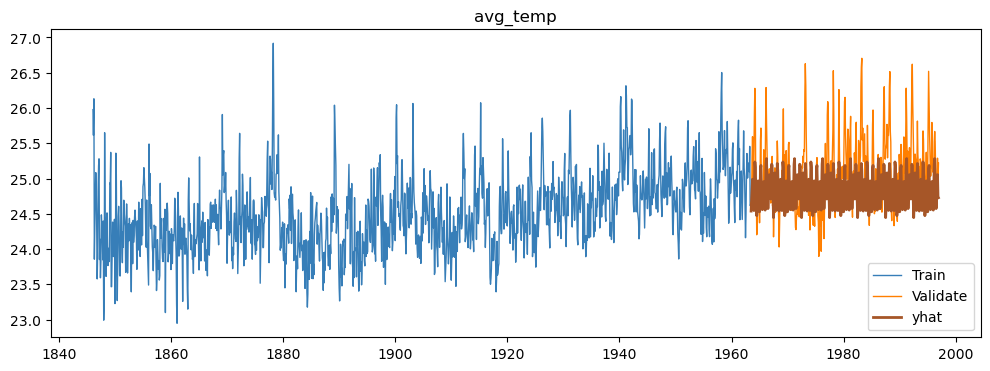

In [28]:
for col in train.columns:
    plot_and_eval(col)

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_mul', 
                            target_var = col)
    
eval_df.sort_values('rmse')    

,model_type,target_var,rmse
1,9mo_moving_avg,avg_temp,0.499906
2,holts_seasonal_add_mul,avg_temp,0.504957
0,last_observed_value,avg_temp,0.688604


### Test data subset 

In [30]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [31]:
yhat_df = pd.DataFrame({'avg_temp': hst_temp_fit4.forecast(validate.shape[0] + test.shape[0])})
yhat_df

,avg_temp
1963-06-30,24.538876
1963-07-31,24.682250
1963-08-31,24.818923
1963-09-30,24.990287
1963-10-31,24.692583
...,...
2013-04-30,24.804696
2013-05-31,24.689016
2013-06-30,24.538876
2013-07-31,24.682250


In [32]:
yhat_df = yhat_df['1996-12-31':]

In [33]:
# function for final plot
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [34]:
rmse_amount = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

In [35]:
train = train.iloc[:,0]
train = pd.DataFrame(train)
test = test.iloc[:,0]
test = pd.DataFrame(test)

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-amount:  0.7622679422244562


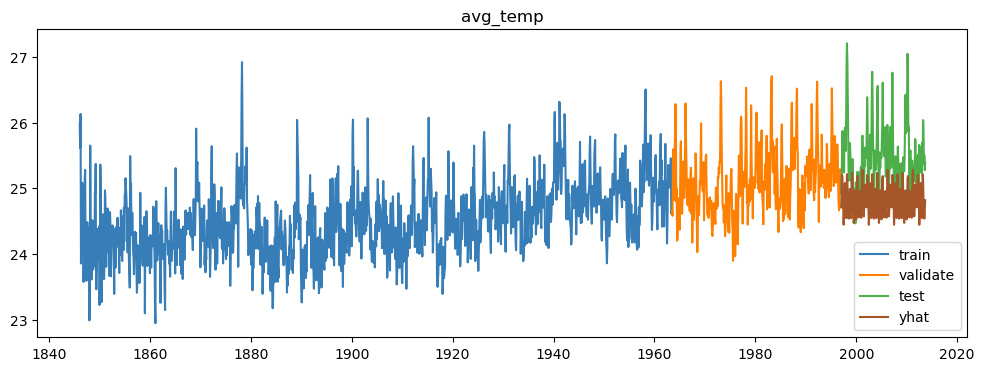

In [36]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-amount: ', rmse_amount)
for col in train.columns:
    final_plot(col)

### Forecasting Colombia's weather for the next 5 years

In [37]:
forecast = pd.DataFrame({'avg_temp': hst_temp_fit4.forecast(validate.shape[0] + test.shape[0] + 60)})
forecast = forecast['2013-08-31':]
forecast

,avg_temp
2013-08-31,24.818923
2013-09-30,24.990287
2013-10-31,24.692583
2013-11-30,24.673818
2013-12-31,24.546014
...,...
2018-04-30,24.804696
2018-05-31,24.689016
2018-06-30,24.538876
2018-07-31,24.682250


In [38]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

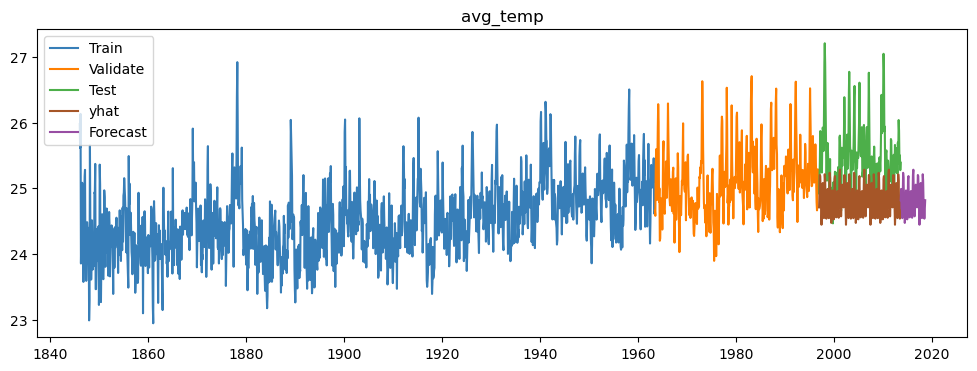

In [39]:
for col in train.columns:
    final_plot(col)

### Modeling Summary & Evaluation 

**The best performing model visually seems to be the holts seasonsal. I decided to use that model and run my test data subset on the model. I then used to forcast the weather.**

------

<div class="alert alert-info">
    <header>
    <h2>Conclusions:</h2>    
</header>    
<dt>
    
Colombia's weather forecasting was measured used by minimizing RMSE within our models. The 9 month moving average had the best RMSE, but I decided to go with the Holts seasonal becuase my forecasting came out better. 
<br>        
